[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers 

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.
 
## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [32]:
%%capture --no-stderr
%pip install --quiet -U "langchain-core>=0.3.78,<1.0.0" "langgraph>=0.2.50,<0.3.0"

## Default overwriting state

Let's use a `TypedDict` as our state schema.

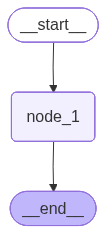

In [33]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    score: int

def node_1(state):
    print("---Node 1---")
    return {"score": state['score'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
graph.invoke({"score" : 1})

---Node 1---


{'score': 2}

Let's look at the state update, `return {"score": state['score'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `score` in `node_1`: 

```
return {"score": state['score'] + 1}
```
 
If we pass `{'score': 1}` as input, the state returned from the graph is `{'score': 2}`.

## Branching

Let's look at a case where our nodes branch.

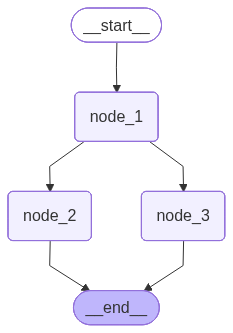

In [35]:
class State(TypedDict):
    score: int

def node_1(state):
    print("---Node 1---")
    return {"score": state['score'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"score": state['score'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"score": state['score'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"score" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'score': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

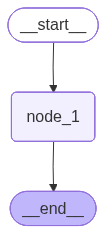

In [37]:
from operator import add
from typing import Annotated

class State(TypedDict):
    score: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"score": [state['score'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
graph.invoke({"score" : [1]})

---Node 1---


{'score': [1, 2]}

Now, our state key `score` is a list.

This `operator.add` reducer function will append updates from each node to this list.

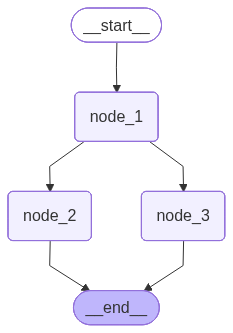

In [39]:
def node_1(state):
    print("---Node 1---")
    return {"score": [state['score'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"score": [state['score'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"score": [state['score'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [40]:
graph.invoke({"score" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'score': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `score`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`.

In [41]:
try:
    graph.invoke({"score" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [42]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    score: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    score: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

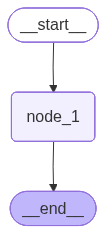

TypeError occurred: can only concatenate list (not "NoneType") to list


In [43]:
def node_1(state):
    print("---Node 1---")
    return {"score": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"score" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

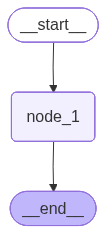

---Node 1---
{'score': [2]}


In [44]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"score" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

These two are equivalent. 

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [45]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [46]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on cricket statistics.", name="Akshit")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='ca5b92df-e775-4a46-b144-cf50efa42554'),
 HumanMessage(content="I'm looking for information on cricket statistics.", additional_kwargs={}, response_metadata={}, name='Akshit', id='05c985c9-44e2-4931-b875-3af00df2cdc9'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='aae6fc3c-b5aa-4d3d-9f3e-eb0cf2e19729')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [47]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on cricket statistics.", name="Akshit", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on T20 cricket, specifically", name="Akshit", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on T20 cricket, specifically", additional_kwargs={}, response_metadata={}, name='Akshit', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [48]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Akshit", id="2"))
messages.append(AIMessage("So you said you were researching cricket stats?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about ODI. But what about T20 formats should I learn about?", name="Akshit", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [49]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching cricket stats?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about ODI. But what about T20 formats should I learn about?', additional_kwargs={}, response_metadata={}, name='Akshit', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

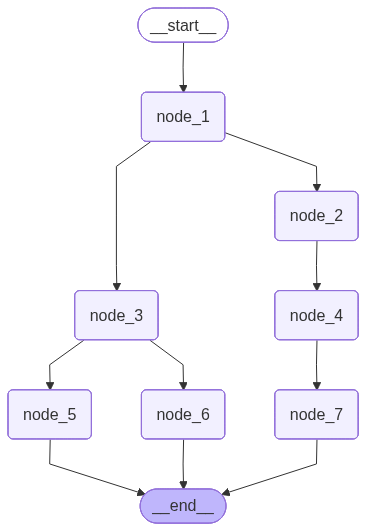

In [50]:
# Trying out my own examples below with extended branching
class State(TypedDict):
    score: int

def node_1(state):
    print("---Node 1---")
    return {"score": state['score'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"score": state['score'] + 2}

def node_3(state):
    print("---Node 3---")
    return {"score": state['score'] + 1}

def node_4(state):
    print("---Node 4---")
    return {"score": state['score'] + 3}

def node_5(state):
    print("---Node 5---")
    return {"score": state['score'] + 2}

def node_6(state):
    print("---Node 6---")
    return {"score": state['score'] + 5}

def node_7(state):
    print("---Node 7---")
    return {"score": state['score'] + 4}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)
builder.add_node("node_5", node_5)
builder.add_node("node_6", node_6)
builder.add_node("node_7", node_7)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", "node_5")
builder.add_edge("node_3", "node_6")
builder.add_edge("node_4", "node_7")
builder.add_edge("node_5", END)
builder.add_edge("node_6", END)
builder.add_edge("node_7", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"score" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'score': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


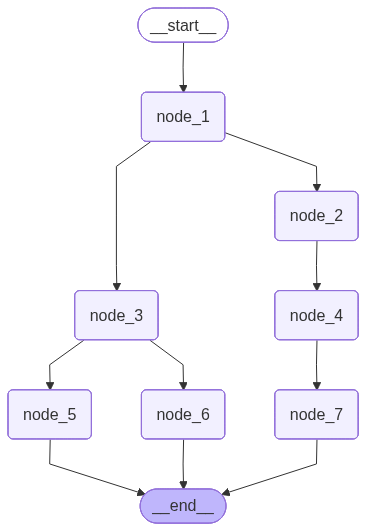

In [52]:
from operator import add
from typing import Annotated

class State(TypedDict):
    score: Annotated[list[int], add]
    
def node_1(state):
    print("---Node 1---")
    return {"score": [state['score'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"score": [state['score'][-1] + 2]}

def node_3(state):
    print("---Node 3---")
    return {"score": [state['score'][-1] + 1]}

def node_4(state):
    print("---Node 4---")
    return {"score": [state['score'][-1] + 3]}

def node_5(state):
    print("---Node 5---")
    return {"score": [state['score'][-1] + 2]}

def node_6(state):
    print("---Node 6---")
    return {"score": [state['score'][-1] + 5]}

def node_7(state):
    print("---Node 7---")
    return {"score": [state['score'][-1] + 4]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)
builder.add_node("node_5", node_5)
builder.add_node("node_6", node_6)
builder.add_node("node_7", node_7)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", "node_5")
builder.add_edge("node_3", "node_6")
builder.add_edge("node_4", "node_7")
builder.add_edge("node_5", END)
builder.add_edge("node_6", END)
builder.add_edge("node_7", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
graph.invoke({"score" : [1]})

---Node 1---
---Node 2---
---Node 3---
---Node 4---
---Node 5---
---Node 6---
---Node 7---


{'score': [1, 2, 4, 3, 6, 5, 8, 12]}

In [54]:
try:
    graph.invoke({"score" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


In [55]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    score: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    score: Annotated[list[int], reduce_list]

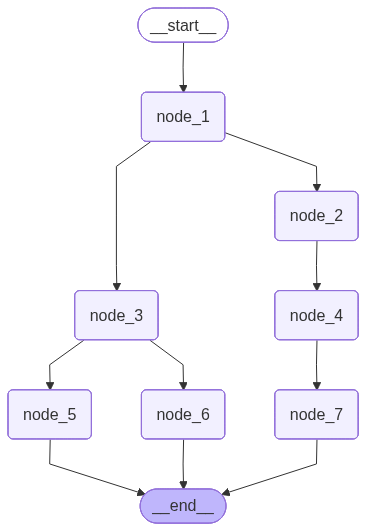

In [56]:
def node_1(state):
    print("---Node 1---")
    return {"score": [2]}
    
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)
builder.add_node("node_5", node_5)
builder.add_node("node_6", node_6)
builder.add_node("node_7", node_7)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", "node_4")
builder.add_edge("node_3", "node_5")
builder.add_edge("node_3", "node_6")
builder.add_edge("node_4", "node_7")
builder.add_edge("node_5", END)
builder.add_edge("node_6", END)
builder.add_edge("node_7", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
try:
    print(graph.invoke({"score" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
---Node 4---
---Node 5---
---Node 6---
---Node 7---
{'score': [2, 4, 3, 6, 5, 8, 12]}
---Node 6---
---Node 7---
{'score': [2, 4, 3, 6, 5, 8, 12]}


# Now that the custom reducer has worked on the modified graph, moving on to messages.

In [58]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on machine learning algorithms.", name="Akshit")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='f129b34a-39e0-4e25-a02f-95560db18a03'),
 HumanMessage(content="I'm looking for information on machine learning algorithms.", additional_kwargs={}, response_metadata={}, name='Akshit', id='cc8a12cd-0543-4e21-a454-ee8c55525cea'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='aeffd103-22cb-447a-a27a-5df4b4d845aa')]

# Rewriting messages by introducing message_id

In [59]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="101"),
                    HumanMessage(content="I'm looking for information on cricket statistics.", name="Akshit", id="21")
                   ]

new_message = HumanMessage(content="I'm looking for information on T20 cricket, specifically", name="Akshit", id="21")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='101'),
 HumanMessage(content="I'm looking for information on T20 cricket, specifically", additional_kwargs={}, response_metadata={}, name='Akshit', id='21')]

# It is observed that not only the message, but the name of the person can be rewritten too

In [60]:
# Rewriting both message and name
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="101"),
                    HumanMessage(content="I'm looking for information on sports.", name="Akshit", id="21")
                   ]

new_message = HumanMessage(content="I'm looking for information on cricket statistics.", name="Baliyan", id="21")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='101'),
 HumanMessage(content="I'm looking for information on cricket statistics.", additional_kwargs={}, response_metadata={}, name='Baliyan', id='21')]

# Moving on to removal of messages

In [61]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Akshit", id="2"))
messages.append(AIMessage("So you said you were researching T20 cricket?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about batting. But what about bowling strategies should I learn about?", name="Akshit", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-3]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1')]


In [62]:
add_messages(messages , delete_messages)

[HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Akshit', id='2'),
 AIMessage(content='So you said you were researching T20 cricket?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about batting. But what about bowling strategies should I learn about?', additional_kwargs={}, response_metadata={}, name='Akshit', id='4')]